# Прогнозирование температуры звезды

## Описание

Пришла задача от заказчика: необходимо определять температуру на поверхности обнаруженных звёзд. 

Обычно для расчёта температуры применяются следующие методы:
- Закон смещения Вина;
- Закон Стефана-Больцмана;
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Заказчик хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

## Импорт библиотек

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from math import ceil
import optuna
from optuna.trial import TrialState
import warnings
warnings.filterwarnings("ignore")

## Загрузка и предобработка данных

Загрузим данные.

In [2]:
data = pd.read_csv("6_class.csv")

In [3]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,4,1939,0.000138,0.1030,20.06,0,Red


1-ый и 2-ой столбец дублируют индексы записей.

In [4]:
data = data.drop(["Unnamed: 0.1","Unnamed: 0"], axis=1)

Подкорректируем названия столбцов.

In [5]:
col_to_replace = data.columns
col_to_replace = [col.lower() for col in col_to_replace]
col_to_replace = [col.replace(" ", "_") for col in col_to_replace]
data.columns = col_to_replace

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   temperature_(k)         240 non-null    int64  
 1   luminosity(l/lo)        240 non-null    float64
 2   radius(r/ro)            240 non-null    float64
 3   absolute_magnitude(mv)  240 non-null    float64
 4   star_type               240 non-null    int64  
 5   star_color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


Категориальные переменные приведем к соответствующему типу.

In [7]:
data.star_type = data.star_type.astype("category")
data.star_color = data.star_color.astype("category")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   temperature_(k)         240 non-null    int64   
 1   luminosity(l/lo)        240 non-null    float64 
 2   radius(r/ro)            240 non-null    float64 
 3   absolute_magnitude(mv)  240 non-null    float64 
 4   star_type               240 non-null    category
 5   star_color              240 non-null    category
dtypes: category(2), float64(3), int64(1)
memory usage: 9.0 KB


In [8]:
data.isna().sum()

temperature_(k)           0
luminosity(l/lo)          0
radius(r/ro)              0
absolute_magnitude(mv)    0
star_type                 0
star_color                0
dtype: int64

Пропуски отсутствуют.

In [9]:
data.duplicated().sum()

0

Дубликаты отсутствуют.

Изучим категориальные признаки на неявные дубликаты.

In [10]:
data.star_color.value_counts()

star_color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
white                   3
Yellowish White         3
Whitish                 2
yellowish               2
Orange                  2
Blue                    1
White-Yellow            1
Orange-Red              1
Yellowish               1
Blue-White              1
Blue white              1
Pale yellow orange      1
Name: count, dtype: int64

Много неявных дубликатов, устраним.

In [11]:
data.star_color = data.star_color.str.strip()
data.star_color = data.star_color.str.lower()
data.star_color = data.star_color.str.replace(" ", "-")
data.loc[data.star_color == "white-yellow", "star_color"] = "yellow-white"

In [12]:
data.star_color.value_counts()

star_color
red                   112
blue                   56
blue-white             41
white                  10
yellow-white            9
yellowish-white         3
yellowish               3
whitish                 2
orange                  2
pale-yellow-orange      1
orange-red              1
Name: count, dtype: int64

**Выводы:**

В рамках предобработки данных:
- найдены и устранены два неинформативных столбца;
- приведены к единому регистру названия признаков;
- найдены и устранены неявные дубликаты;
- заменены типы данных там где это требовалось.

[В начало](#intro)

## Исследовательский анализ данных

Изучим сами данные.

In [13]:
data.describe()

,temperature_(k),luminosity(l/lo),radius(r/ro),absolute_magnitude(mv)
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


Визуализируем выбросы.

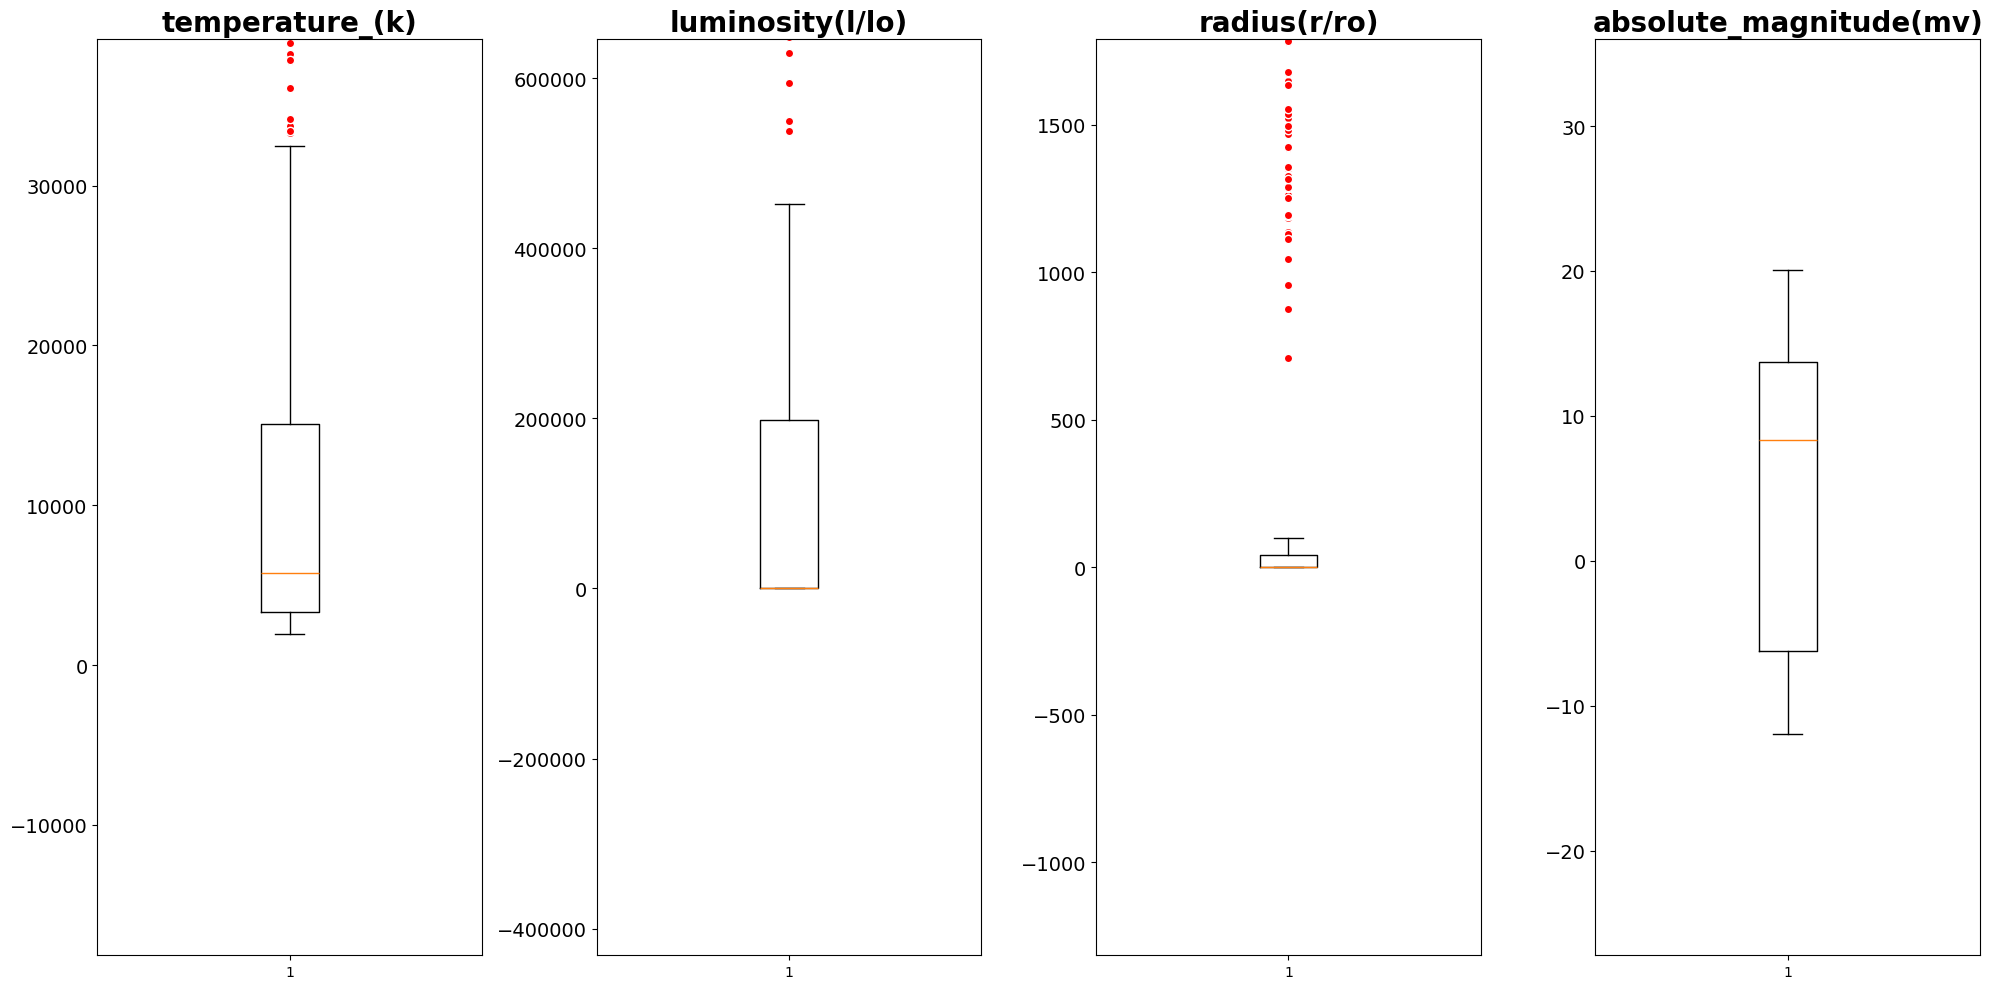

In [14]:
data_box = data.select_dtypes(include=[int,float])

red_circle = dict(markerfacecolor="red", marker="o", markeredgecolor="white")
fig, axs = plt.subplots(1, len(data_box.columns), figsize=(20, 10))

for i, ax in enumerate(axs):
    ax.boxplot(data_box.iloc[:, i], flierprops=red_circle)
    ax.set_title(data_box.columns[i], fontsize=20, fontweight="bold")
    ax.tick_params(axis="y", labelsize=14)
    ax.set_ylim(data_box.iloc[:, i].mean() - 3 * data_box.iloc[:, i].std(), 
                data_box.iloc[:, i].mean() + 3 * data_box.iloc[:, i].std())

plt.tight_layout()

del data_box

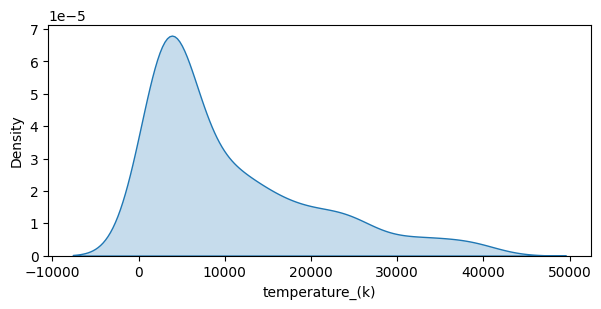

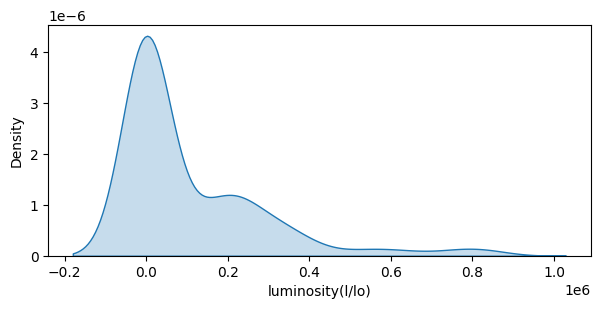

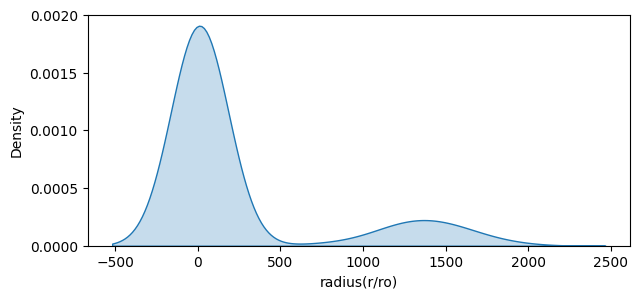

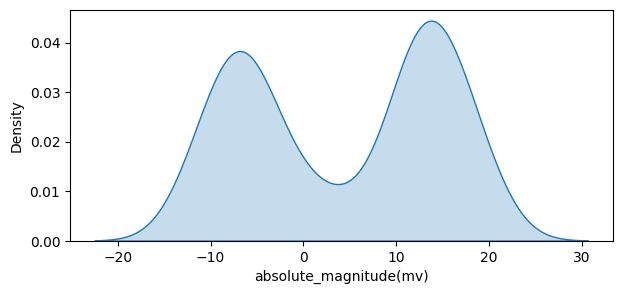

In [15]:
for col in data.select_dtypes(include=[int,float]).columns:
    plt.subplots(1, figsize=(7, 3))
    sns.kdeplot(data[col], fill=True)
    plt.show()

Кажется, что выбросы не такие большие. Для полной картины также оценим зависимость между данными.

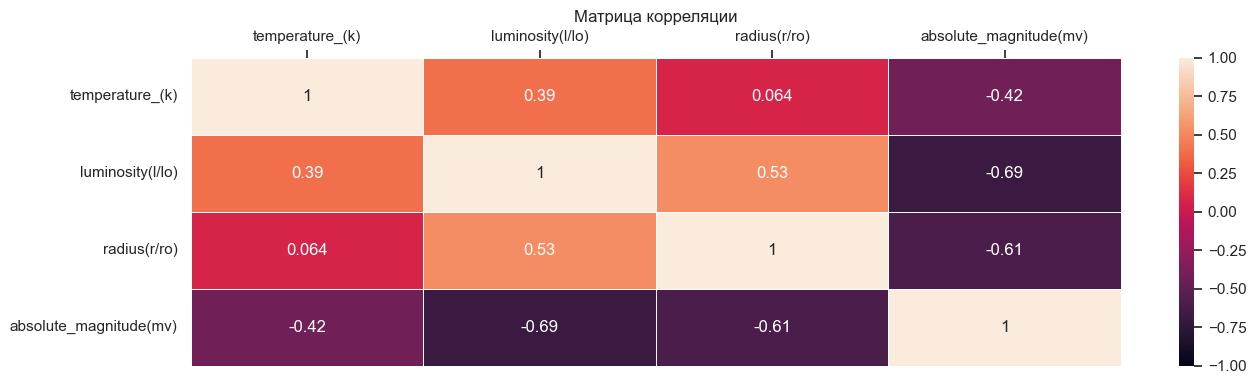

In [16]:
corr_matrix = data.select_dtypes(include=["int", "float"]).corr()

sns.set_theme(style="white")
plt.figure(figsize = (15, 4))
sns.heatmap(corr_matrix,
            vmin=-1, 
            vmax=1,
            annot=True,
            linewidths=.5
           ).xaxis.tick_top()
plt.title("Матрица корреляции")
plt.show()

del corr_matrix

В данных наблюдаются выбросы, однако, не спешим их устранять, поскольку изучаемые характеристики объектов, возможно выходят за рамками нормального распределения.

- Темпертура на звездах может сильно разниться, у большинство звезд температура поверхности от 0 до 40 градусов Цельсия. Некоторые звезды имеют температуру поверхности до 100 и больше. На температуру влиюят показатели светимость звезды относительно Солнца прямым образом, с ростом температуры на поверхности звезды растет светимость звезды. При этом блеск звезды падает, блеск больше если темперура на звезде низкая.
- Светимость звезды отноистельно Солнца также величина с выбросами. Светимость звезды тем больше, чем больше радиус планеты и тем меньше, чем больше блеск планеты.
- Радиус звезд относительно радиуса Солнца также с выбросами, среди звезд наблюдаются массивные звезды. Чем больше звезда, тем ниже блекс и тем больше светимость относительно Солнца.
- Блекс звезд без выбросов, с ростом всех предыдущих параметров блекс звезд падает.

Посмотрим как распрелены количественные данные в разрезе категориальных данных. Как распределены данные в зависимости от цвета звезды?

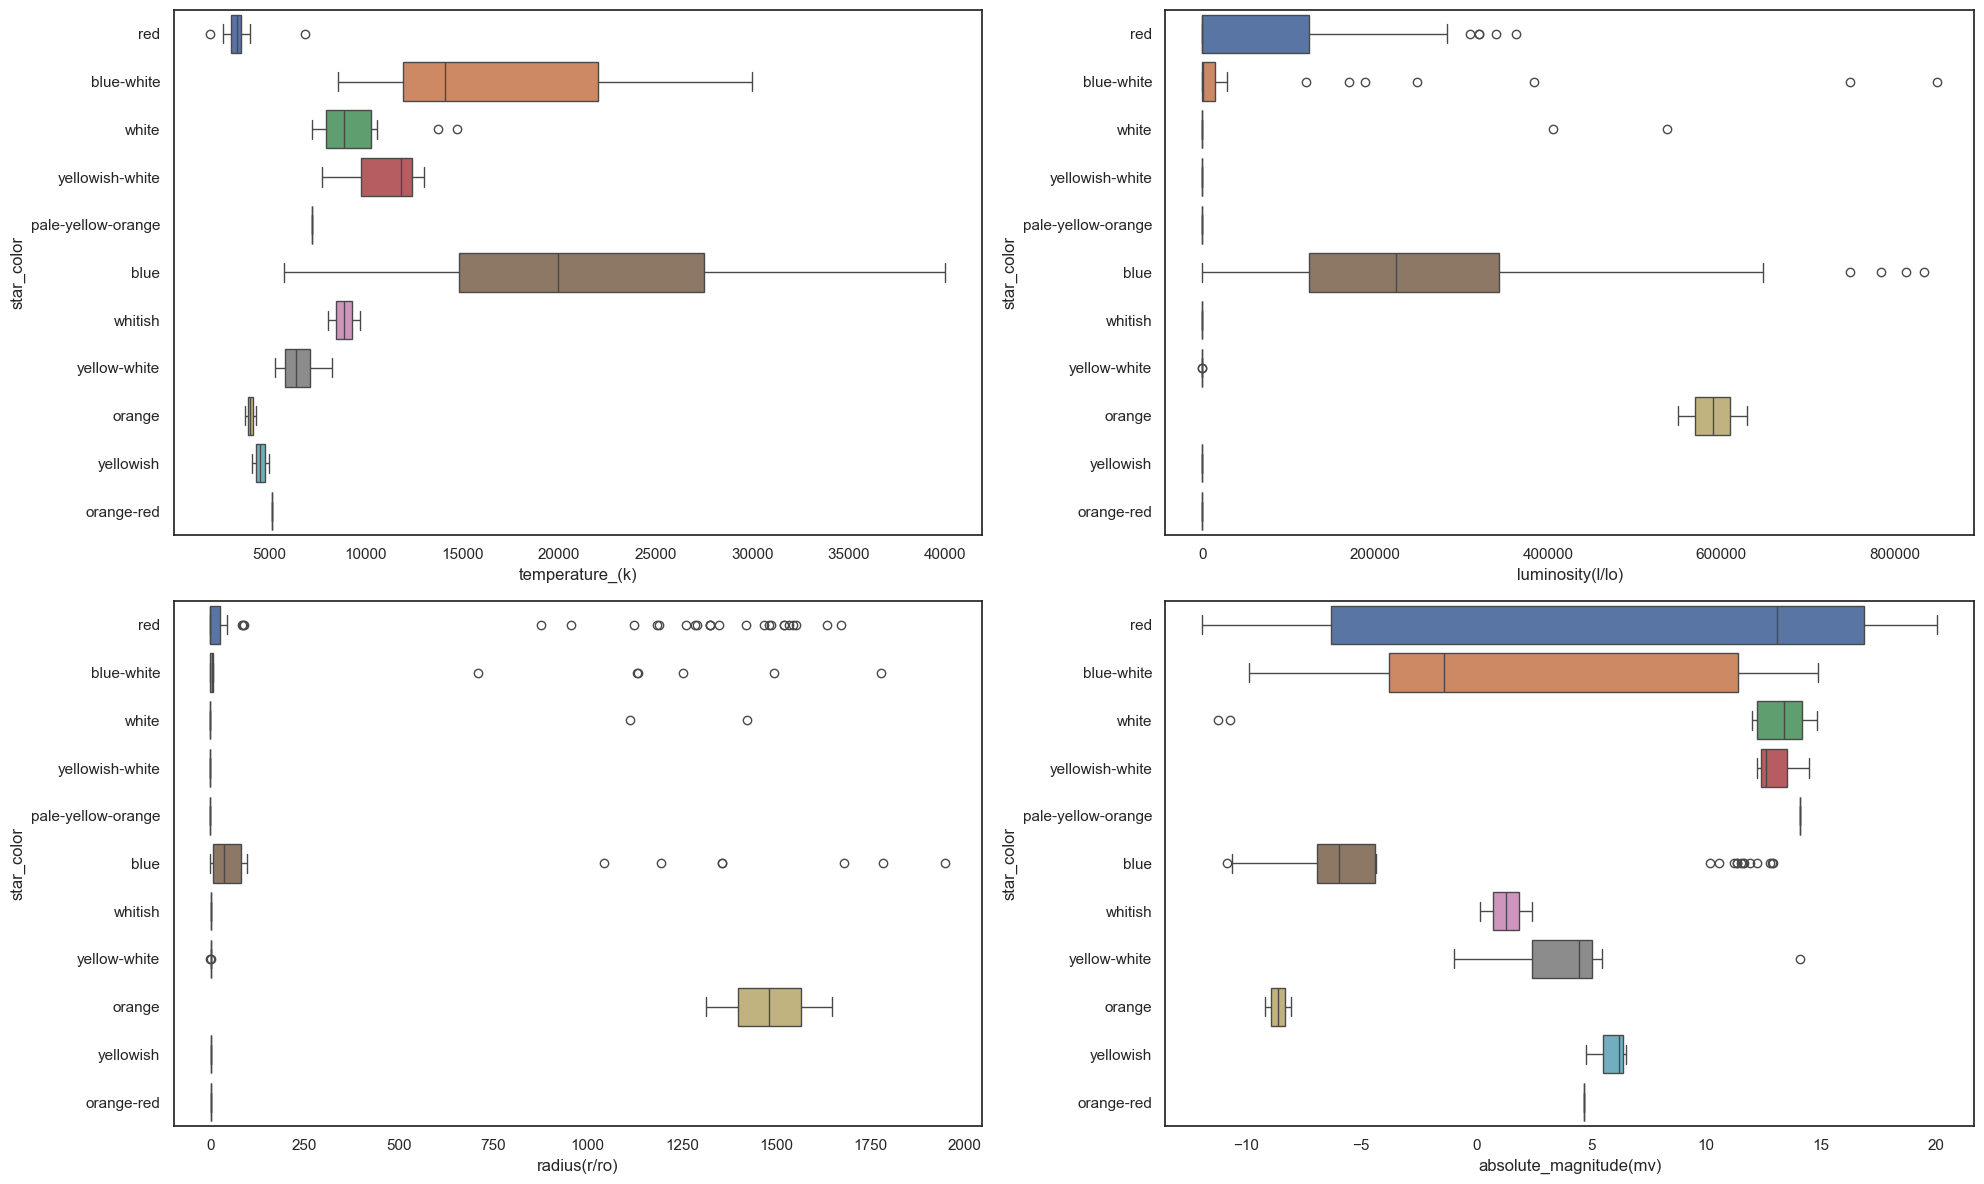

In [17]:
fig, axs = plt.subplots(2, 2,  figsize=(20, 12))

sns.boxplot(data=data, x="temperature_(k)", y="star_color", ax=axs[0,0], palette="deep")
sns.boxplot(data=data, x="luminosity(l/lo)", y="star_color", ax=axs[0,1], palette="deep")
sns.boxplot(data=data, x="radius(r/ro)", y="star_color", ax=axs[1,0], palette="deep")
sns.boxplot(data=data, x="absolute_magnitude(mv)", y="star_color", ax=axs[1,1], palette="deep")
plt.tight_layout()

Как распределены данные в зависимости от типа звезды?

In [18]:
star_type_dict = {
    "Коричневый карлик":0,
    "Красный карлик":1,
    "Белый карлик":2,
    "Звёзды главной последовательности":3,
    "Сверхгигант":4,
    "Гипергигант":5
}
star_type_dict = pd.DataFrame(star_type_dict.items(), columns=["value","star_type"])

In [19]:
data = data.merge(star_type_dict, how='left', on='star_type')

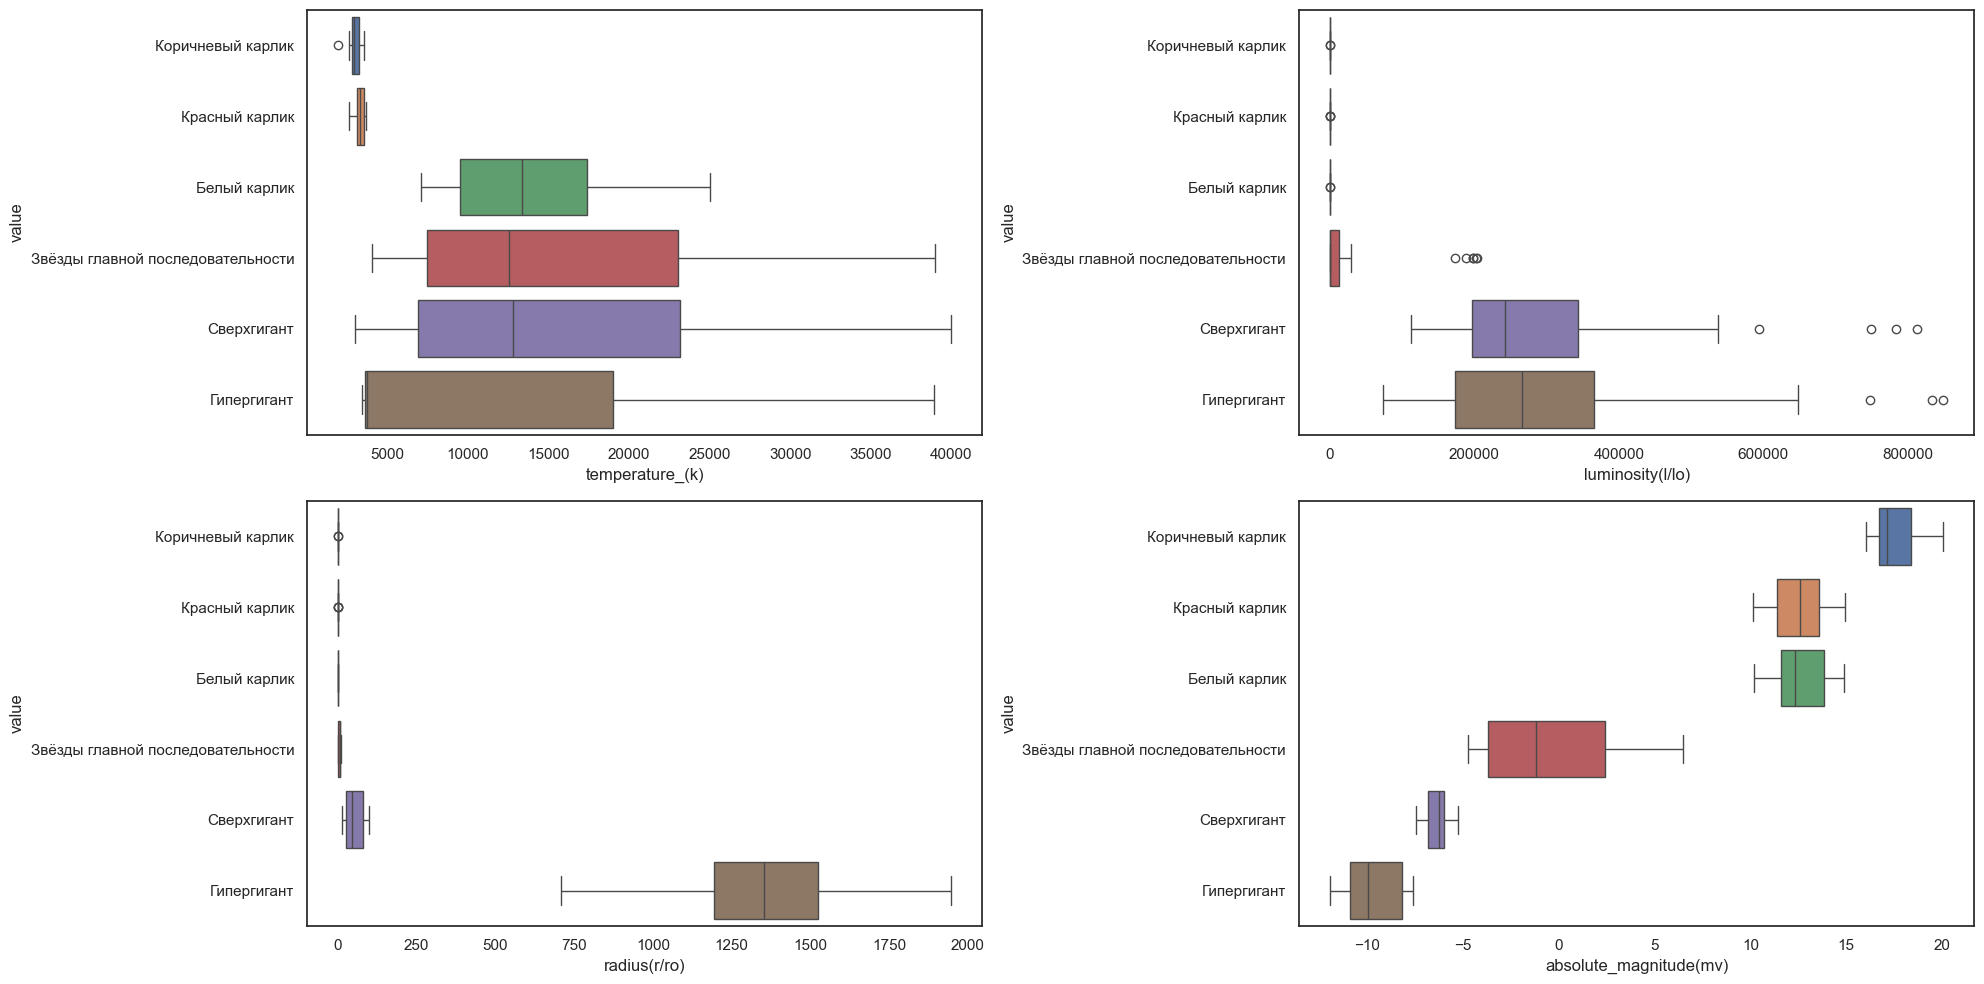

In [20]:
fig, axs = plt.subplots(2, 2,  figsize=(20, 10))
sns.boxplot(data=data, x="temperature_(k)", y="value", ax=axs[0,0], palette="deep")
sns.boxplot(data=data, x="luminosity(l/lo)", y="value", ax=axs[0,1], palette="deep")
sns.boxplot(data=data, x="radius(r/ro)", y="value", ax=axs[1,0], palette="deep")
sns.boxplot(data=data, x="absolute_magnitude(mv)", y="value", ax=axs[1,1], palette="deep");
plt.tight_layout()

- Самые жаркие звезды это звезды с голубым и бело-голубым цветом;
- Самые крупные звезды относительно радиуса Солнца это оранжевые и голубые звезды, причем первые в десятки раз больше всех остальных звезд.
- Как и отмечалось ранее светимость звезды больше, чем больше размер радиус звезды относительно Солнца, в разрезе цветов светимость больше у тех звезд у которых радиус наибольший.
- Высказанные выводы подветждаются, блекс звезды больше по цветам, если радиус звезды меньше.

In [21]:
data = data.drop("value", axis=1)
data.head()

,temperature_(k),luminosity(l/lo),radius(r/ro),absolute_magnitude(mv),star_type,star_color
0,3068,0.002400,0.1700,16.12,0,red
1,3042,0.000500,0.1542,16.60,0,red
2,2600,0.000300,0.1020,18.70,0,red
3,2800,0.000200,0.1600,16.65,0,red
4,1939,0.000138,0.1030,20.06,0,red


**Выводы**

Исследовательский анализ показал:
- в данных наюлюдаются выбросы, пока устранять их не будем;
- признаки коррелируют не только с целевым признаком, но и между собой, наблюдается мультиколлинеарность.

[В начало](#intro)

## Построение базовой нейронной сети

Заменим типы данных там, где нужно.

In [22]:
data.star_type = data.star_type.astype("category")
data.star_color = data.star_color.astype("category")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   temperature_(k)         240 non-null    int64   
 1   luminosity(l/lo)        240 non-null    float64 
 2   radius(r/ro)            240 non-null    float64 
 3   absolute_magnitude(mv)  240 non-null    float64 
 4   star_type               240 non-null    category
 5   star_color              240 non-null    category
dtypes: category(2), float64(3), int64(1)
memory usage: 8.7 KB


Разобъем наши данные на признаки и целевой признак.

In [23]:
X,y = data.drop("temperature_(k)", axis=1), data["temperature_(k)"]

Масштабирем наши признаки.

In [24]:
scalar = StandardScaler()
numeric = X.select_dtypes(include=float).columns
X[numeric] = scalar.fit_transform(X[numeric])
X.head(2)

,luminosity(l/lo),radius(r/ro),absolute_magnitude(mv),star_type,star_color
0,-0.598624,-0.459210,1.116745,0,red
1,-0.598624,-0.459241,1.162414,0,red


Применим OHE к категориальным переменным.

In [25]:
X = pd.get_dummies(X, drop_first=True) * 1
X.head(2)

,luminosity(l/lo),radius(r/ro),absolute_magnitude(mv),star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue-white,star_color_orange,star_color_orange-red,star_color_pale-yellow-orange,star_color_red,star_color_white,star_color_whitish,star_color_yellow-white,star_color_yellowish,star_color_yellowish-white
0,-0.598624,-0.459210,1.116745,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,-0.598624,-0.459241,1.162414,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [26]:
X.shape[1]

18

На входном слоуе у нас 18 нейронов.

Разобъем данные на тренировочные и тестовые.

In [27]:
state = 12345

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=state)

X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

Построим базовую нейронную сеть.

In [29]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ELU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)    
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

n_in_neurons = X.shape[1]
n_hidden_neurons_1 = 25
n_hidden_neurons_2 = 17
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

loss = nn.MSELoss()

num_epochs = 1000 # наша выборка небольшая поэтому используем много эпох

for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    loss_value = loss(preds,y_train)
    loss_value.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs:
        print("Эпоха: ", epoch)

        train_preds = net.forward(X_train)
        r2_train = np.round(r2_score(y_train, train_preds.detach().numpy()), 2)
        rmse_train = np.round(mean_squared_error(y_train, train_preds.detach().numpy(), squared=False))
        print(f"r2_train: {r2_train}, rmse_train: {rmse_train}")

        net.eval()
        test_preds = net.forward(X_test)
        test_preds = test_preds.flatten().detach().numpy()
        r2_test = np.round(r2_score(y_test, test_preds), 2)
        rmse_test = np.round(mean_squared_error(y_test, test_preds, squared=False))
        print(f"r2_test:  {r2_test}, rmse_test: {rmse_test}")

# сохраним наши результаты
batch_size = None
learning_rate = None
drop_out = None
data = {
    "epoch": epoch, 
    "batch_size": batch_size, 
    "learning_rate": learning_rate, 
    "drop_out": drop_out, 
    "rmse_train": rmse_train, 
    "rmse_test": rmse_test, 
    "r2_train": r2_train, 
    "r2_test": r2_test}
results = pd.DataFrame([data])

Эпоха:  0
r2_train: -1.22, rmse_train: 13662.0
r2_test:  -1.24, rmse_test: 16084.0
Эпоха:  100
r2_train: -0.85, rmse_train: 12481.0
r2_test:  -0.86, rmse_test: 14678.0
Эпоха:  200
r2_train: 0.25, rmse_train: 7914.0
r2_test:  0.28, rmse_test: 9110.0
Эпоха:  300
r2_train: 0.42, rmse_train: 6968.0
r2_test:  0.39, rmse_test: 8408.0
Эпоха:  400
r2_train: 0.51, rmse_train: 6425.0
r2_test:  0.44, rmse_test: 8015.0
Эпоха:  500
r2_train: 0.61, rmse_train: 5741.0
r2_test:  0.56, rmse_test: 7158.0
Эпоха:  600
r2_train: 0.76, rmse_train: 4504.0
r2_test:  0.7, rmse_test: 5925.0
Эпоха:  700
r2_train: 0.82, rmse_train: 3883.0
r2_test:  0.77, rmse_test: 5150.0
Эпоха:  800
r2_train: 0.84, rmse_train: 3660.0
r2_test:  0.82, rmse_test: 4520.0
Эпоха:  900
r2_train: 0.85, rmse_train: 3554.0
r2_test:  0.84, rmse_test: 4270.0


На тестовых данных мы выполняем условие, что значение целевой метрики RMSE должно быть меньше 4500. Немного прокачаем нашу сеть добавив батчи.

In [30]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ELU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)     
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

n_in_neurons = X.shape[1]
n_hidden_neurons_1 = 25
n_hidden_neurons_2 = 17
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2) 

loss = nn.MSELoss()

batch_size = 50
num_epochs = 1000

num_batches = ceil(len(X_train)/batch_size)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size 
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        optimizer.zero_grad()
        preds = net.forward(X_batch).flatten() 
        loss_value = loss(preds,y_batch) 
        loss_value.backward()
        optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs:
        print("Эпоха: ", epoch)
    
        train_preds = net.forward(X_train)
        r2_train = np.round(r2_score(y_train, train_preds.detach().numpy()), 2)
        rmse_train = np.round(mean_squared_error(y_train, train_preds.detach().numpy(), squared=False))
        print(f"r2_train: {r2_train}, rmse_train: {rmse_train}")

        net.eval()
        test_preds = net.forward(X_test)
        test_preds = test_preds.flatten().detach().numpy()
        r2_test = np.round(r2_score(y_test, test_preds), 2)
        rmse_test = np.round(mean_squared_error(y_test, test_preds, squared=False))
        print(f"r2_test:  {r2_test}, rmse_test: {rmse_test}")

learning_rate = None
drop_out = None
data = {
    "epoch": epoch, 
    "batch_size": batch_size, 
    "learning_rate": learning_rate, 
    "drop_out": drop_out, 
    "rmse_train": rmse_train, 
    "rmse_test": rmse_test, 
    "r2_train": r2_train, 
    "r2_test": r2_test}
results = pd.concat([results, pd.DataFrame([data])])

Эпоха:  0
r2_train: -1.22, rmse_train: 13662.0
r2_test:  -1.24, rmse_test: 16083.0
Эпоха:  100
r2_train: 0.47, rmse_train: 6692.0
r2_test:  0.45, rmse_test: 7995.0
Эпоха:  200
r2_train: 0.78, rmse_train: 4329.0
r2_test:  0.72, rmse_test: 5696.0
Эпоха:  300
r2_train: 0.83, rmse_train: 3773.0
r2_test:  0.82, rmse_test: 4585.0
Эпоха:  400
r2_train: 0.84, rmse_train: 3679.0
r2_test:  0.83, rmse_test: 4379.0
Эпоха:  500
r2_train: 0.84, rmse_train: 3628.0
r2_test:  0.84, rmse_test: 4334.0
Эпоха:  600
r2_train: 0.85, rmse_train: 3594.0
r2_test:  0.84, rmse_test: 4334.0
Эпоха:  700
r2_train: 0.85, rmse_train: 3564.0
r2_test:  0.84, rmse_test: 4259.0
Эпоха:  800
r2_train: 0.85, rmse_train: 3540.0
r2_test:  0.84, rmse_test: 4269.0
Эпоха:  900
r2_train: 0.85, rmse_train: 3515.0
r2_test:  0.85, rmse_test: 4182.0


Значение метрики стало лучше и на тестовом и на тренировочном датасете.

Напишем функцию для визуализации фактических и полученных значений. 

In [31]:
def vizual(y_pred, y_true):
    
    x = np.arange(len(y_true))

    fig,ax = plt.subplots()
    fig.set_figwidth(18)
    fig.set_figheight(8)
    ax.set_xticks(x)
    fact = ax.bar(x, y_true, width = 0.9, label = 'Факт', color="lightblue")
    forecast = ax.bar(x, y_pred , width = 0.4, label = 'Прогноз', color="gold")
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('Номер звезды')
    ax.set_ylabel('Температура звезды')
    plt.show()

Для нашей сети визуализируем данные.

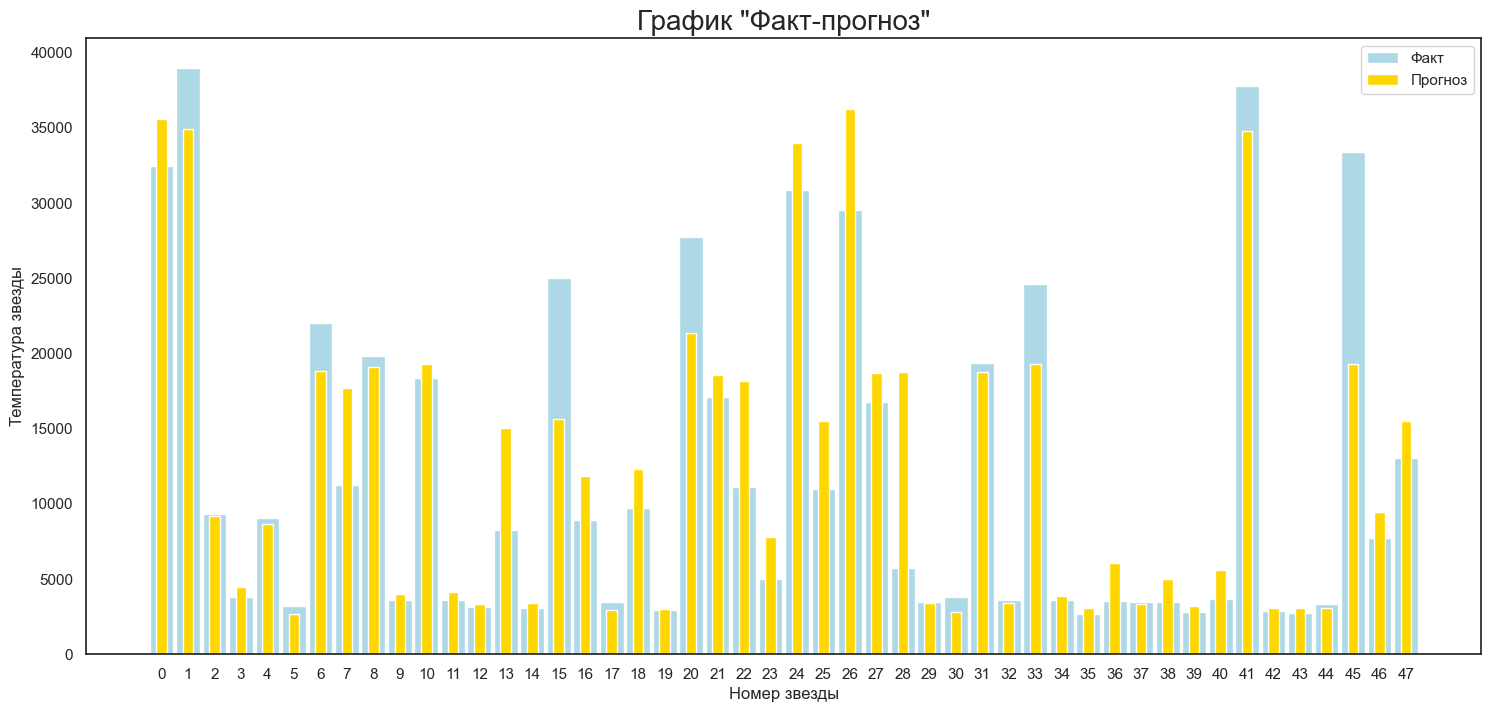

In [32]:
vizual(test_preds, y_test)

[В начало](#intro)

## Улучшение нейронной сети

Посмотрим насколько качество нейросети изменится после автотюнинга. При этом архитектуру нейронной сети изменять не будем, чтобы понять насколько автотюнинг лучше справляется с задачей подбора гиперпараметров.

In [33]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ELU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(drop_out)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)     
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        return x

def objective(trial):
    
    num_epochs = 1000
    
    n_in_neurons = X.shape[1]
    n_hidden_neurons_1 = 25
    n_hidden_neurons_2 = 17
    n_out_neurons = 1
    
    learning_rate =  trial.suggest_float('learning_rate', 0.001, 0.1) #, step=0.005)
    drop_out = trial.suggest_float('drop_out', 0.1, 0.3) #, step=0.1)  
    batch_size = trial.suggest_int('batch_size', 30, 80) #, step=5)
    
    net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    loss = nn.MSELoss()
    
    num_batches = ceil(len(X_train)/batch_size)
    
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            
            optimizer.zero_grad()
            preds = net.forward(X_batch).flatten() 
            loss_value = loss(preds,y_batch) 
            loss_value.backward()
            optimizer.step()
    
    with torch.no_grad():
        
        net.eval()
        test_preds = net.forward(X_test)
        test_preds = test_preds.flatten().detach().numpy()
        r2 = r2_score(y_test, test_preds)
        rmse = mean_squared_error(y_test, test_preds, squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=state), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)

print("Лучшие параметры:", study.best_params)
print("Лучшее оптимальное значение целевой функции:", study.best_value)

[I 2024-03-07 17:00:36,976] A new study created in memory with name: no-name-c60fd677-b06a-4f25-82e4-f9921d929bba
[I 2024-03-07 17:00:39,353] Trial 0 finished with value: 4738.31103515625 and parameters: {'learning_rate': 0.09303199318889764, 'drop_out': 0.16327511091635719, 'batch_size': 39}. Best is trial 0 with value: 4738.31103515625.
[I 2024-03-07 17:00:41,261] Trial 1 finished with value: 4607.501953125 and parameters: {'learning_rate': 0.021251467576750935, 'drop_out': 0.21354500581633734, 'batch_size': 60}. Best is trial 1 with value: 4607.501953125.
[I 2024-03-07 17:00:42,741] Trial 2 finished with value: 4828.2470703125 and parameters: {'learning_rate': 0.09648693745382654, 'drop_out': 0.23063541937431417, 'batch_size': 68}. Best is trial 1 with value: 4607.501953125.
[I 2024-03-07 17:00:44,214] Trial 3 finished with value: 4792.17529296875 and parameters: {'learning_rate': 0.0657034172143218, 'drop_out': 0.24954296185425476, 'batch_size': 79}. Best is trial 1 with value: 460

Лучшие параметры: {'learning_rate': 0.023338123045543308, 'drop_out': 0.14899488804837283, 'batch_size': 70}
Лучшее оптимальное значение целевой функции: 4051.93701171875


Результаты тюнинга неплохие, обучим новую нейросеть с подобранными тюнингом значениями гиперпараметров.

In [34]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

learning_rate = study.best_params["learning_rate"]
drop_out = study.best_params["drop_out"]
batch_size = study.best_params["batch_size"]

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ELU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(drop_out)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)     
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        return x
   
n_in_neurons = X.shape[1]
n_hidden_neurons_1 = 25
n_hidden_neurons_2 = 17
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
loss = nn.MSELoss()
     
num_epochs = 1000
batch_size = batch_size

num_batches = ceil(len(X_train)/batch_size)

best_loss = None
counter = 0
patience = 4

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size 
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        optimizer.zero_grad()
        preds = net.forward(X_batch).flatten() 
        loss_value = loss(preds,y_batch) 
        loss_value.backward()
        optimizer.step()

    if epoch % 50 == 0 or epoch == num_epochs:
        print("Эпоха: ", epoch)
    
        train_preds = net.forward(X_train)
        r2_train = np.round(r2_score(y_train, train_preds.detach().numpy()), 2)
        rmse_train = np.round(mean_squared_error(y_train, train_preds.detach().numpy(), squared=False))
        print(f"r2_train: {r2_train}, rmse_train: {rmse_train}")

        net.eval()
        test_preds = net.forward(X_test)
        test_preds = test_preds.flatten().detach().numpy()
        r2_test = np.round(r2_score(y_test, test_preds), 2)
        rmse_test = np.round(mean_squared_error(y_test, test_preds, squared=False))
        print(f"r2_test:  {r2_test}, rmse_test: {rmse_test}")

        # Добавим критерий остановы        
        if best_loss == None:
            best_loss = loss_value
        elif best_loss - loss_value > 0:
            best_loss = loss_value
            counter = 0
        elif best_loss - loss_value < 0:
            counter += 1
        if counter >= patience:
            print('Ранняя остановка:', epoch)
            break

data = {
    "epoch": epoch, 
    "batch_size": batch_size, 
    "learning_rate": learning_rate, 
    "drop_out": drop_out, 
    "rmse_train": rmse_train, 
    "rmse_test": rmse_test, 
    "r2_train": r2_train, 
    "r2_test": r2_test}
results = pd.concat([results, pd.DataFrame([data])])

Эпоха:  0
r2_train: -1.22, rmse_train: 13661.0
r2_test:  -1.24, rmse_test: 16083.0
Эпоха:  50
r2_train: 0.42, rmse_train: 6977.0
r2_test:  0.42, rmse_test: 8218.0
Эпоха:  100
r2_train: 0.6, rmse_train: 5794.0
r2_test:  0.57, rmse_test: 7071.0
Эпоха:  150
r2_train: 0.8, rmse_train: 4086.0
r2_test:  0.77, rmse_test: 5178.0
Эпоха:  200
r2_train: 0.83, rmse_train: 3795.0
r2_test:  0.81, rmse_test: 4656.0
Эпоха:  250
r2_train: 0.84, rmse_train: 3686.0
r2_test:  0.83, rmse_test: 4396.0
Эпоха:  300
r2_train: 0.84, rmse_train: 3625.0
r2_test:  0.84, rmse_test: 4344.0
Эпоха:  350
r2_train: 0.85, rmse_train: 3594.0
r2_test:  0.84, rmse_test: 4245.0
Эпоха:  400
r2_train: 0.85, rmse_train: 3569.0
r2_test:  0.85, rmse_test: 4193.0
Эпоха:  450
r2_train: 0.85, rmse_train: 3537.0
r2_test:  0.85, rmse_test: 4129.0
Эпоха:  500
r2_train: 0.85, rmse_train: 3518.0
r2_test:  0.85, rmse_test: 4107.0
Эпоха:  550
r2_train: 0.85, rmse_train: 3501.0
r2_test:  0.85, rmse_test: 4098.0
Раняя остановка: 550


Нейронная сеть с гиперпараметрами подобранными тюнингом лучше предсказывает температуру на поверхности звезд.

Также визуализируем данные.

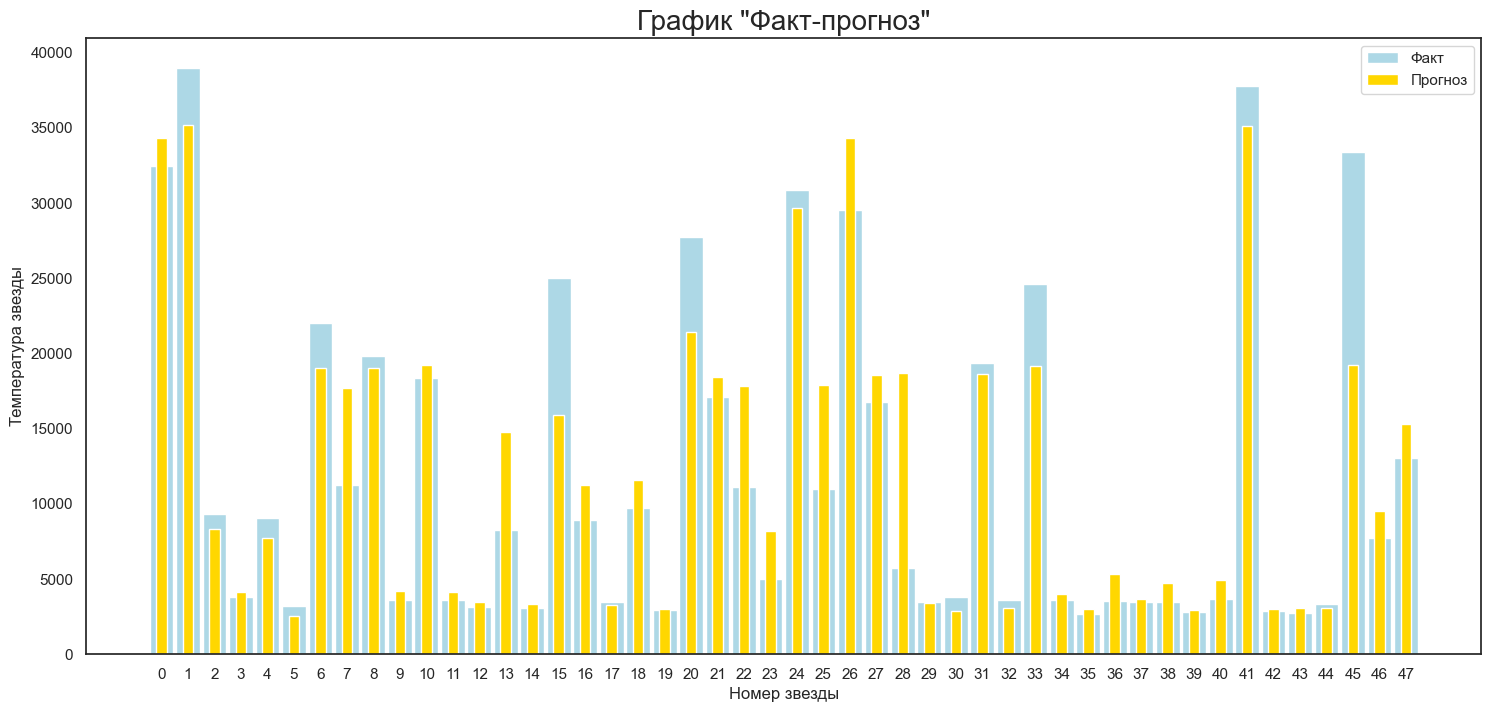

In [39]:
vizual(test_preds, y_test)

Ознакомимся с итоговыми результатами.

In [36]:
results

,epoch,batch_size,learning_rate,drop_out,rmse_train,rmse_test,r2_train,r2_test
0,999,None,NaN,NaN,3554.0,4270.0,0.85,0.84
0,999,50,NaN,NaN,3515.0,4182.0,0.85,0.85
0,550,70,0.023338,0.148995,3501.0,4098.0,0.85,0.85


Сохраняем нашу лучшую нейронну сеть для использования.

In [37]:
torch.save({
            "results": results.iloc[2],
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_value,
            },"net")

[В начало](#intro)

## Выводы

В ходе работы выполнено:
- предобработка и исследовательский анализ данных;
- обучена базовая версия нейросети, а также нейросеть с использованием батчей;
- обучена нейросеть с использованием автотюнинга, результаты можно наблюдать в таблице ниже;
- достинута целевая метрика обучения.

In [38]:
results

,epoch,batch_size,learning_rate,drop_out,rmse_train,rmse_test,r2_train,r2_test
0,999,None,NaN,NaN,3554.0,4270.0,0.85,0.84
0,999,50,NaN,NaN,3515.0,4182.0,0.85,0.85
0,550,70,0.023338,0.148995,3501.0,4098.0,0.85,0.85


Исходя из данных видно автотюнинг лучше подбирает гиперпараметры нейронной сети, при большем количестве подбираемых гиперпараметров и их значений возможно достигнуть хороших показателей.

[В начало](#intro)